## Capacitated Vehicle Routing Problem

>**Given** A fleet of identical vehicles, with limited capacity, located at a depot; $n$ customers that require service with known demand; cost of travel between any pair of customers, or between any customer and the depot.

>**Find** A minimum-cost collection of vehicle routes, each starting and ending at the depot, such that each customer is visited by exactly one vehicle, and no vehicle visits a set of customers whose total demand exceeds the vehicle capacity.

Let $G=(V,A)$ be a directed graph with node $1$ representing the depot and $V_C=V\setminus{1}$ representing the customers.
The (positive integer) demand of customer $i \in V_C$ is denoted by $q_i$.
For any set of customer $S \subset V_C$ let $q(S)=\sum_{i \in S} q_i$.

### Two-index formulation

$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is some vehicle travels from $i$ to $j$} \\
0 \text{ otherwise}
\end{cases}
$$


$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} \\
\text{subject}& \text{ to} \\
\sum_{j \in \delta^+(i)} x_{ij} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} x_{ji} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^+(S)} x_{ij} & \ge \lceil{q(S)/Q} \rceil \;\ \forall S \subseteq V_C\\
 x_{ij} \in \{0,1\} \;\; \forall(i,j) \in A \\
\end{align}
$$

The constraints $\sum_{j \in \delta^+(S)} x_{ij}  \ge \lceil{q(S)/Q} \rceil $ are called *rounded capacity inequalities*

### Single commodity flow formulation

Define a continuous variable $f_{ij}$ for each arc $(i,j) \in A$ representing the load (flow) 
carried from $i$ to $j$. The rounded capacity inequalities can be replaced with:

$$
\sum_{j \in \delta^-(i)} f_{ji} - \sum_{j \in \delta^+(i)} f_{ij} = q_i \;\; \forall i \in V_C\\
0 \le f_{ij} \le Q x_{ij}
$$

### Strengthening

$$q_j x_{ij} \le f_{ij} \le (Q-q_i) x_{ij} \;\; \forall (i,j) \in A$$

Thus, the final formulation reads:


$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is some vehicle travels from $i$ to $j$} \\
0 \text{ otherwise}
\end{cases}
$$


$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} \\
\text{subject}& \text{ to} \\
\sum_{j \in \delta^+(i)} x_{ij} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} x_{ji} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} f_{ji} - \sum_{j \in \delta^+(i)} f_{ij} & = q_i \;\;\forall i \in V_C\\
 q_j x_{ij} \le f_{ij} & \le (Q-q_i) x_{ij}  \;\; \forall (i,j) \in A\\
\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
\end{align}
$$


In [1]:
#!/usr/bin/env python


import networkx as nx
import gurobipy as gb
import argparse
from argparse import ArgumentTypeError
import os
from itertools import combinations
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

G has 15 nodes and 210 edges


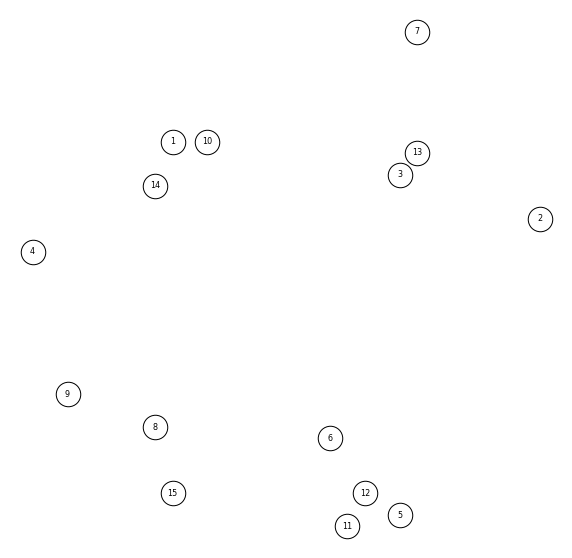

In [3]:
# 
# Read the graph in the graphML format
#

args.filename = 'cvrp.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

depot = list(G.nodes())[0]

DrawInitG(G)



In [4]:
G.nodes(data=True)

NodeDataView({1: {'y': 36, 'x': 9, 'demand': 778}, 2: {'y': 29, 'x': 30, 'demand': 1378}, 3: {'y': 33, 'x': 22, 'demand': 458}, 4: {'y': 26, 'x': 1, 'demand': 1747}, 5: {'y': 2, 'x': 22, 'demand': 1483}, 6: {'y': 9, 'x': 18, 'demand': 180}, 7: {'y': 46, 'x': 23, 'demand': 1518}, 8: {'y': 10, 'x': 8, 'demand': 340}, 9: {'y': 13, 'x': 3, 'demand': 451}, 10: {'y': 36, 'x': 11, 'demand': 1249}, 11: {'y': 1, 'x': 19, 'demand': 129}, 12: {'y': 4, 'x': 20, 'demand': 939}, 13: {'y': 35, 'x': 23, 'demand': 768}, 14: {'y': 32, 'x': 8, 'demand': 1037}, 15: {'y': 4, 'x': 9, 'demand': 1529}})

In [5]:
cvrp = gb.Model("CVRP formulation")

Q = 10000 #vehicle capacity 

dem = nx.get_node_attributes (G,'demand')

dem

Academic license - for non-commercial use only - expires 2021-07-16
Using license file /Users/fabrizio/Solvers/licenses/gurobi.lic


{1: 778,
 2: 1378,
 3: 458,
 4: 1747,
 5: 1483,
 6: 180,
 7: 1518,
 8: 340,
 9: 451,
 10: 1249,
 11: 129,
 12: 939,
 13: 768,
 14: 1037,
 15: 1529}

In [6]:
depot = 1

dem[depot] = 0 ## Depot does not require service

x = cvrp.addVars(G.edges(), \
                 obj=[G[i][j]['dist'] \
                      for i,j in G.edges()], \
                 vtype = gb.GRB.BINARY, name='x')

In [7]:
#
# Flow variables
#


f = cvrp.addVars (G.edges(), obj=0.0, lb=0, \
    ub=Q, vtype=gb.GRB.CONTINUOUS, name='f')

In [8]:
dem

{1: 0,
 2: 1378,
 3: 458,
 4: 1747,
 5: 1483,
 6: 180,
 7: 1518,
 8: 340,
 9: 451,
 10: 1249,
 11: 129,
 12: 939,
 13: 768,
 14: 1037,
 15: 1529}

In [9]:
#
# Assignment constraints
#

#
# Forward star
#

cvrp.addConstrs((x.sum(i,'*') == 1 for i in G.nodes() if i != depot), name='FS')



# Reverse star
#

cvrp.addConstrs((x.sum('*',i) == 1 for i in G.nodes() if i != depot), name='RS')


cvrp.update()

In [10]:
#
# Flow constraints
#

cvrp.addConstrs((f.sum('*',i) - f.sum(i,'*') \
                 == dem[i] for i in G.nodes() if i != depot),\
               name='FLOW')

cvrp.update()

In [11]:
cvrp.addConstrs((f[i,j] <= (Q - dem[i]) * x[i,j] for i,j in G.edges()),name='VUB')

cvrp.update()

In [12]:
cvrp.addConstrs((f[i,j] >= dem[j] * x[i,j] for i,j in G.edges()),name='VLB')

cvrp.update()

In [13]:
cvrp.write('cvrp.lp')

In [14]:
cvrp.optimize()


Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 462 rows, 420 columns and 1610 nonzeros
Model fingerprint: 0x8263e607
Variable types: 210 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 2e+03]
Presolve removed 28 rows and 14 columns
Presolve time: 0.02s
Presolved: 434 rows, 406 columns, 1568 nonzeros
Variable types: 210 continuous, 196 integer (196 binary)
Found heuristic solution: objective 60655.000000

Root relaxation: objective 1.200511e+04, 412 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12005.1124    0   28 60655.0000 12005.1124  80.2%     -    0s
H    0     0                    23499.000000 12

     0     0 14321.5092    0   35 14865.0000 14321.5092  3.66%     -    2s
     0     2 14322.8235    0   35 14865.0000 14322.8235  3.65%     -    2s
*   37     8               8    14864.000000 14462.4135  2.70%  13.8    2s

Cutting planes:
  Gomory: 3
  MIR: 12
  Flow cover: 8
  Flow path: 2
  Inf proof: 1
  Zero half: 2
  Network: 10

Explored 65 nodes (3650 simplex iterations) in 2.63 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 14864 14865 15055 ... 20870

Optimal solution found (tolerance 1.00e-04)
Best objective 1.486400000000e+04, best bound 1.486400000000e+04, gap 0.0000%


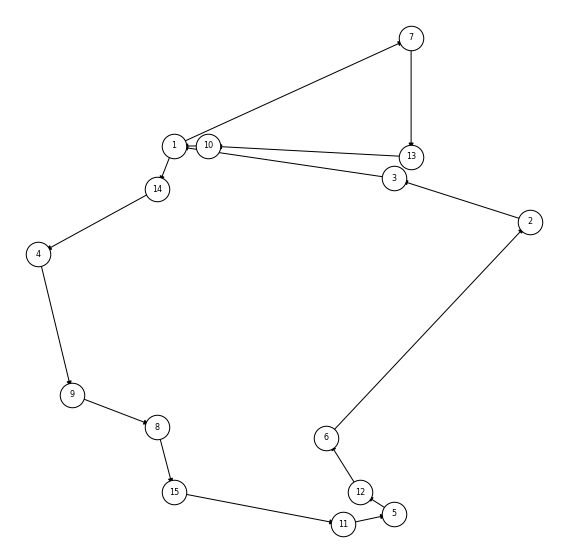

In [15]:
DrawSol(G, x)

In [132]:
for i,j in f:
    if (i == 1) and (f[i,j].x > 0):
        print (f[i,j])

<gurobi.Var f[1,7] (value 3534.9999999999995)>
<gurobi.Var f[1,14] (value 9671.0)>
